# <b> Make sure you are running this in google colab.</b>
Go to the link: https://drive.google.com/drive/folders/1g3SZoPdl1KQOd8cn9Xdi6k_NlN1QaMfJ?usp=sharing and click on <i> "add the shortcut to My Drive" </i>. This will add the shortcut to My Drive.

For a detailed step by step procedure, please open this link to follow the instructions: https://docs.google.com/document/d/1H__QmGhzPT2RfralQ--bwLBz3O-rg6L4/edit?usp=sharing&ouid=107456846675416400203&rtpof=true&sd=true

<b> Before starting your notebook, click on Runtime: Change Runtime to GPU. If not possible, proceed with the GPU runtime. </b>

# Retinal Fundus Multi-disease classification

#### <b>Brief description:</b>
According to the WHO,  World report on vision 2019, the number of visually impaired people worldwide is estimated to be 2.2 billion, of whom at least 1 billion have a vision impairment that could have been prevented or is yet to be addressed. The world faces considerable challenges in terms of eye care, including inequalities in the coverage and quality of prevention, treatment, and rehabilitation services. Early detection and diagnosis of ocular pathologies would enable forestall of visual impairment. One challenge that limits the adoption of a computer-aided diagnosis tool by the ophthalmologist is, the sight-threatening rare pathologies such as central retinal artery occlusion or anterior ischemic optic neuropathy and others are usually ignored.<br> 

Retinal Fundus Multi-disease Image Dataset (RFMiD) consists of fundus images captured using three different fundus cameras with 46 conditions annotated through adjudicated consensus of two senior retinal experts.<br>

We aim to develop generalizable models for screening retina.

| ![picture](https://drive.google.com/uc?export=view&id=1Q2t8UsfyCPv9gkbf4aDupzNnL0QYLbgb)      | ![picture](https://drive.google.com/uc?export=view&id=1gzJ8eGn4rkQQIBUf40FfiPxkfI0a4oEC)                                                                                         |
|:-----------------------------------------------------------------------------------------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| Patient with Age-related macular degeneration (ARMD). <br> It's the leading cause of severe, permanent vision loss in people over age 60. <br>It happens when the small central portion of your retina, called the macula, <br> wears down. | Diabetic retinopathy is a complication of diabetes,  caused by high blood  <br> sugar levels damaging the back of the eye (retina). <br> It can cause blindness if <br> left undiagnosed and untreated.|

The diseases included in the dataset that are mentioned in the source paper of the dataset "Retinal Fundus Multi-Disease Image Dataset (RFMiD). We will use this dataset to classify between the following:

1. DR - Diabetic retinopathy <br>
2. ARMD - Age-related macular degeneration <br>
3. Other diseases. <br>
4. No disease risk. <br>



## Getting Started : Setting up the google drive and installing some packages


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install captum SimpleITK barbar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. Importing libraries

In [3]:
# general python imports
import numpy as np
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import random
from glob import glob

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# pytorch imports
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adadelta
from torch.optim.lr_scheduler import ReduceLROnPlateau

# other python imports
import scipy.ndimage
from scipy import misc
from scipy import stats
import seaborn as sns
from barbar import Bar
import cv2
from tqdm import tqdm_notebook as tqdm


# albumentations imports for augmentation
import albumentations as A

# captum for interpretability
from captum.attr import LayerGradCam

## 2. Getting Your Data Ready.
The training images and test images are stored separately. When we read training and test images, we have to make sure that the labels and  images correspond with each other. 

### 2.1 Reading the Train and Test Image Paths and Corresponding Labels

In [14]:
test_images_path = r"/content/drive/MyDrive/retinal_disease_classification/Evaluation_Set/Validation" # path where training .pngs are stored
train_images_path = r"/content/drive/MyDrive/retinal_disease_classification/Training_Set/Training" # path where test .pngs are stored

# reading image paths for training and test sets and sorting them in numerical order 
# train image paths
train_images = [ x for x in os.listdir(train_images_path) if x.endswith(".png")]
train_images = sorted(train_images, key=lambda f: int(f.split('.')[0]))
train_images = np.array([ os.path.join(train_images_path, x) for x in train_images])

# test image paths
test_images = [ x for x in os.listdir(test_images_path) if x.endswith(".png")]
test_images = sorted(test_images, key=lambda f: int(f.split('.')[0]))
test_images = np.array([os.path.join(test_images_path, x) for x in test_images])

# reading the corresponding train and validation labels
label_train = pd.read_csv(r"/content/drive/MyDrive/retinal_disease_classification/Training_Set/RFMiD_Training_Labels.csv")
label_test =  pd.read_csv(r"/content/drive/MyDrive/retinal_disease_classification/Evaluation_Set/RFMiD_Validation_Labels.csv")


In [15]:
# Checking if the train images and train labels are correctly read
print("############# Training Image Paths: #############\n", train_images[:4])
print("############# Training Image Labels: #############\n", label_train.head())


print("############# Test Image Paths: #############\n", test_images[:4])
print("############# Test Image Labels: #############\n", label_test.head())


############# Training Image Paths: #############
 ['/content/drive/MyDrive/retinal_disease_classification/Training_Set/Training/1.png'
 '/content/drive/MyDrive/retinal_disease_classification/Training_Set/Training/2.png'
 '/content/drive/MyDrive/retinal_disease_classification/Training_Set/Training/3.png'
 '/content/drive/MyDrive/retinal_disease_classification/Training_Set/Training/4.png']
############# Training Image Labels: #############
    ID  Disease_Risk  DR  ARMD  MH  DN  MYA  BRVO  TSLN  ERM  ...  CME  PTCR  \
0   1             1   1     0   0   0    0     0     0    0  ...    0     0   
1   2             1   1     0   0   0    0     0     0    0  ...    0     0   
2   3             1   1     0   0   0    0     0     0    0  ...    0     0   
3   4             1   0     0   1   0    0     0     0    0  ...    0     0   
4   5             1   1     0   0   0    0     0     0    0  ...    0     0   

   CF  VH  MCA  VS  BRAO  PLQ  HPED  CL  
0   0   0    0   0     0    0     0   0

### 2.2 Assigning the Labels
The dataset containing labels corresponding to multiple diseases. Some of the diseases contain only a few images corresponding to the diseases. Here we want to classify between No disease risk, DR, ARMD, and other diseases. We will assign them new labels 0, 1, 2, and 3 respectively. 

In [16]:
keys_labels = label_train.keys()     # getting the column name information from the dataframe
print("The dataset contains labels corresponding to multiple diseases:")
print(keys_labels)

The dataset contains labels corresponding to multiple diseases:
Index(['ID', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN',
       'ERM', 'LS', 'MS', 'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST',
       'AION', 'PT', 'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'CWS',
       'CB', 'ODPM', 'PRH', 'MNF', 'HR', 'CRAO', 'TD', 'CME', 'PTCR', 'CF',
       'VH', 'MCA', 'VS', 'BRAO', 'PLQ', 'HPED', 'CL'],
      dtype='object')


In [17]:
index_disease_risk = 1
index_dr = 2
index_armd = 3
new_labels = ["no disease risk", "diabetic retinopathy", "age related macular degeneration", "other diseases"]

# This function assigns new labels
def assign_labels(arr_labels):

  new_labels = list() # storing new labels

  for idx in range(arr_labels.shape[0]):
     
     # assign label for disease risk
     if arr_labels[idx][index_disease_risk] == 0:
       temp_label = 0

     # assign label for disease diabetic retinopathy 
     elif arr_labels[idx][index_dr] == 1:
       temp_label = 1

     # assign label for age related macular degeneration
     elif arr_labels[idx][index_armd] == 1:
       temp_label = 2
      
     # assign labels if there is a disease risk and it does not belong to ARMD and DR
     else:
       temp_label = 3

     new_labels.append(temp_label)
    
  return new_labels

train_labels = np.vstack(assign_labels(label_train.to_numpy())) # getting the numpy values from the dataframe and assigning new labels
test_labels = np.vstack(assign_labels(label_test.to_numpy())) # getting the numpy values from the dataframe and assigning new labels

print("The new labels are as follows: No Disease - 0, Diabetic Retinopathy - 1, Age Related Macular Degeneration - 2, Other disease - 3")

The new labels are as follows: No Disease - 0, Diabetic Retinopathy - 1, Age Related Macular Degeneration - 2, Other disease - 3


### 2.3 Visualizing Labels and Images

 Label :  [3] - other diseases
/content/drive/MyDrive/retinal_disease_classification/Training_Set/Training/1483.png
(1424, 2144, 3)


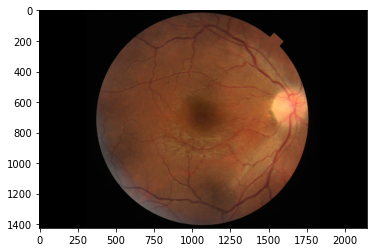

#####################################################################
 Label :  [3] - other diseases
/content/drive/MyDrive/retinal_disease_classification/Training_Set/Training/57.png
(1424, 2144, 3)


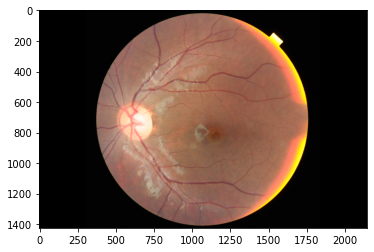

#####################################################################
 Label :  [3] - other diseases
/content/drive/MyDrive/retinal_disease_classification/Training_Set/Training/1143.png
(1424, 2144, 3)


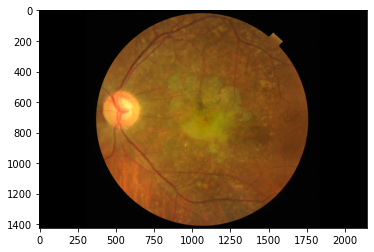

#####################################################################
 Label :  [3] - other diseases
/content/drive/MyDrive/retinal_disease_classification/Training_Set/Training/1244.png
(1424, 2144, 3)


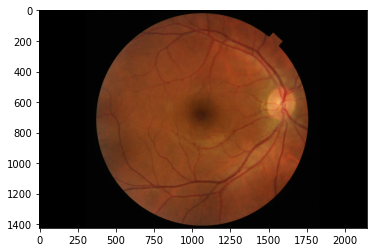

#####################################################################
 Label :  [2] - age related macular degeneration
/content/drive/MyDrive/retinal_disease_classification/Training_Set/Training/924.png
(1424, 2144, 3)


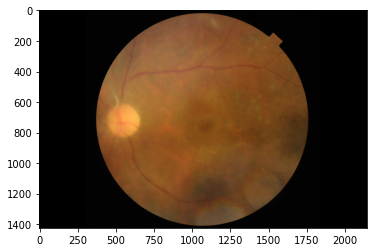

#####################################################################
 Label :  [1] - diabetic retinopathy
/content/drive/MyDrive/retinal_disease_classification/Training_Set/Training/1757.png
(1536, 2048, 3)


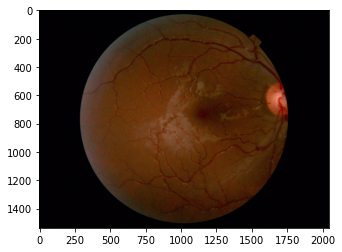

#####################################################################
 Label :  [1] - diabetic retinopathy
/content/drive/MyDrive/retinal_disease_classification/Training_Set/Training/1687.png
(2848, 4288, 3)


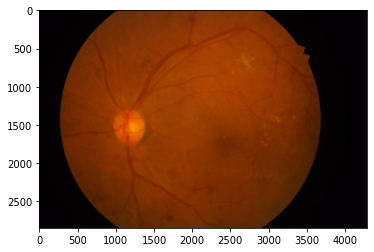

#####################################################################
 Label :  [3] - other diseases
/content/drive/MyDrive/retinal_disease_classification/Training_Set/Training/95.png
(1424, 2144, 3)


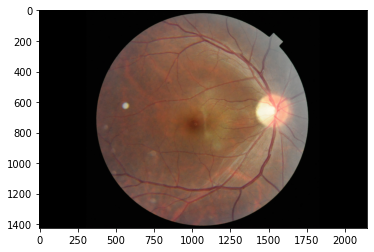

#####################################################################
 Label :  [3] - other diseases
/content/drive/MyDrive/retinal_disease_classification/Training_Set/Training/1764.png
(1536, 2048, 3)


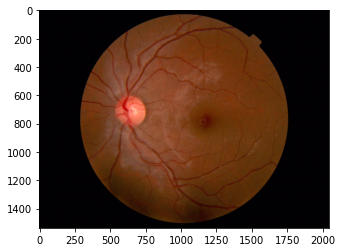

#####################################################################
 Label :  [3] - other diseases
/content/drive/MyDrive/retinal_disease_classification/Training_Set/Training/1252.png
(1424, 2144, 3)


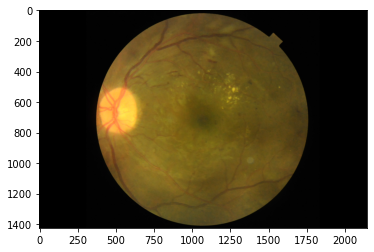

#####################################################################


In [8]:
# Visualizing random images from the training dataset
for i in range(10):
  t_idx = np.random.randint(0, len(train_labels))
  print(" Label : ", train_labels[t_idx], "-", new_labels[int(train_labels[t_idx])])
  plt.figure()
  print(train_images[t_idx])
  temp_img = np.flip(cv2.imread(train_images[t_idx]), 2)
  print(temp_img.shape)
  plt.imshow(temp_img)
  plt.show()
  print("#####################################################################")


### 2.4 Stratified cross Validation

![picture](https://drive.google.com/uc?export=view&id=1SbaPKu9xMech1PZda7ueHrN8C4E08oLY)   

Cross-validation is a statistical approach used to evaluate and compare learning algorithms by dividing data into two segments; one is to learn or train a model and the other is used to validate the model. In Stratified cross validation, the folds are made by preserving the percentage of samples for each class.


In [18]:
kf = StratifiedKFold(n_splits=5)
retinal_kf = [x for x in kf.split(train_images, train_labels)]

In [19]:
FOLD_NUM = 0 # defining the fold number for 5-fold cross validation

# getting training and validation images
cv_train_images= train_images[retinal_kf[FOLD_NUM][0]]
cv_val_images = train_images[retinal_kf[FOLD_NUM][1]]

# getting training and validation labels 
cv_train_labels= train_labels[retinal_kf[FOLD_NUM][0]]
cv_val_labels = train_labels[retinal_kf[FOLD_NUM][1]]


In [20]:
print("Number of per-class instances in the training set: \n")

for class_idx, class_val in enumerate(new_labels):
  print("Idx : ", class_idx, " - ", class_val)
  print("number of class instances: " , np.sum(cv_train_labels == class_idx))

Number of per-class instances in the training set: 

Idx :  0  -  no disease risk
number of class instances:  321
Idx :  1  -  diabetic retinopathy
number of class instances:  300
Idx :  2  -  age related macular degeneration
number of class instances:  80
Idx :  3  -  other diseases
number of class instances:  835


In [21]:
print("Number of per-class instances in the Validation set: \n")

for class_idx, class_val in enumerate(new_labels):
  print("Idx : ", class_idx, " - ", class_val)
  print("number of class instances: " , np.sum(cv_val_labels == class_idx))

Number of per-class instances in the Validation set: 

Idx :  0  -  no disease risk
number of class instances:  80
Idx :  1  -  diabetic retinopathy
number of class instances:  76
Idx :  2  -  age related macular degeneration
number of class instances:  20
Idx :  3  -  other diseases
number of class instances:  208


In [22]:
print("Number of per-class instances in the test set: \n")

for class_idx, class_val in enumerate(new_labels):
  print("Idx : ", class_idx, " - ", class_val)
  print("number of class instances: " , np.sum(test_labels == class_idx))

Number of per-class instances in the test set: 

Idx :  0  -  no disease risk
number of class instances:  134
Idx :  1  -  diabetic retinopathy
number of class instances:  132
Idx :  2  -  age related macular degeneration
number of class instances:  38
Idx :  3  -  other diseases
number of class instances:  336


### 2.4 Pre-processing the images
We pre-process the images to standardize the image values. Here, we visualize the effect of image resizing and mean standard deviation normalization.

 Label :  [3] - other diseases


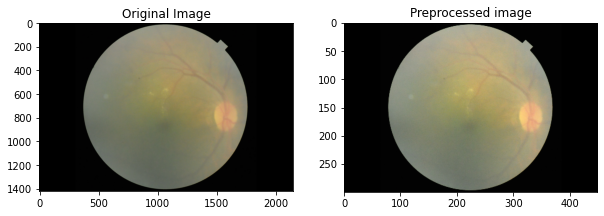

 Label :  [3] - other diseases


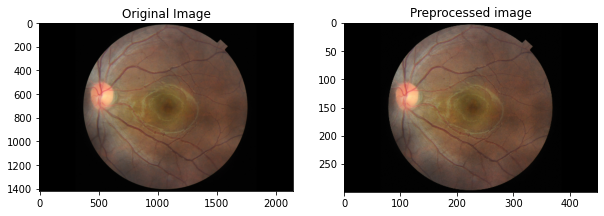

 Label :  [3] - other diseases


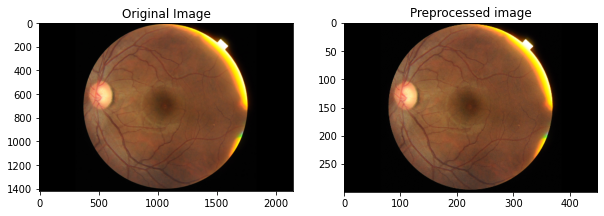

 Label :  [1] - diabetic retinopathy


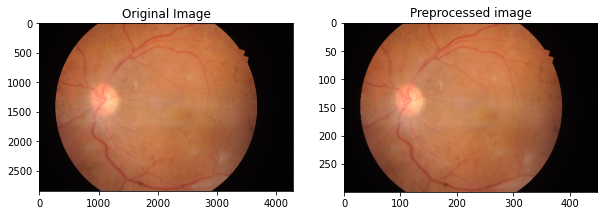

 Label :  [3] - other diseases


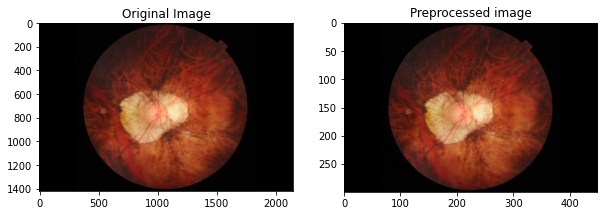

 Label :  [0] - no disease risk


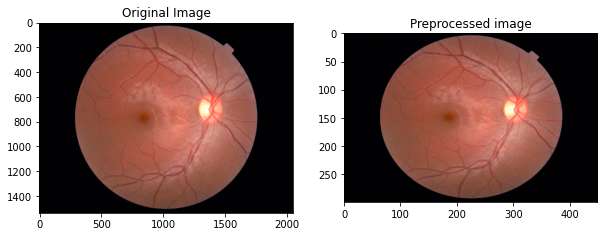

 Label :  [3] - other diseases


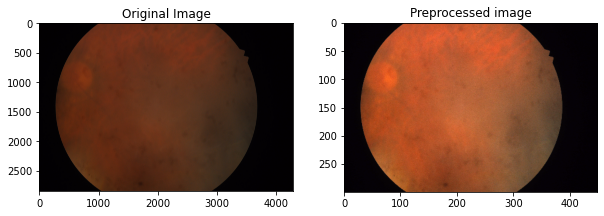

 Label :  [1] - diabetic retinopathy


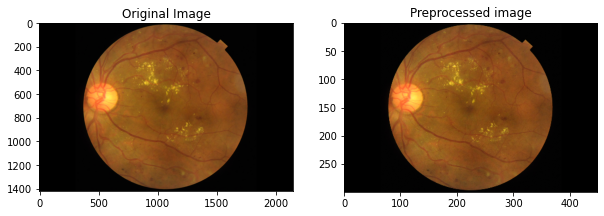

 Label :  [3] - other diseases


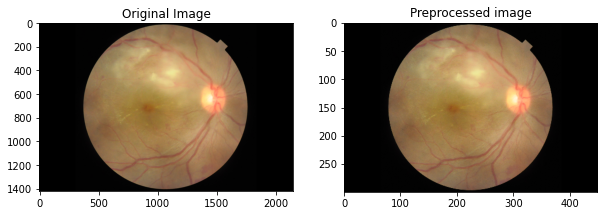

 Label :  [0] - no disease risk


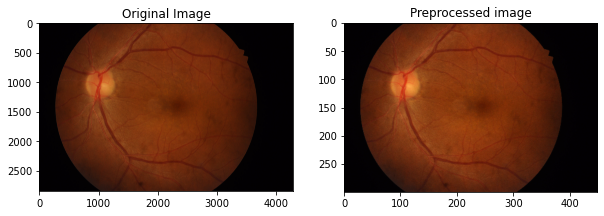

In [23]:
def pre_process(img_arr):
  # min max normalization
  img_arr = cv2.resize(img_arr, (450, 300))
  img_arr = (img_arr - np.min(img_arr))/(np.max(img_arr) - np.min(img_arr))
  return img_arr


# Visualizing random images from the training dataset before and after pre-processing
for i in range(10):
  t_idx = np.random.randint(0, len(train_labels))
  print(" Label : ", train_labels[t_idx], "-", new_labels[int(train_labels[t_idx])])

  plt.figure(figsize=(10,10))
  plt.subplot(1,2,1)
  plt.title("Original Image")
  temp_img = np.flip(cv2.imread(train_images[t_idx]), 2)
  plt.imshow(temp_img)

  plt.subplot(1,2,2)
  plt.title("Preprocessed image")
  p_temp_img = pre_process(temp_img)
  plt.imshow(p_temp_img)
  plt.show()


### 2.5 Generating train, validation

In [24]:
# generating training array
train_img_arr = []
for img_n in tqdm(cv_train_images):
  temp_img_arr = cv2.imread(img_n) # reading the image using opencv
  temp_img_arr = np.flip(temp_img_arr, 2)
  temp_img_arr = pre_process(temp_img_arr)  # pre_processing the image
  train_img_arr.append(np.expand_dims(temp_img_arr, axis=0))
train_img_arr = np.vstack(train_img_arr)
print("The size of the training array is: ", train_img_arr.shape)

<ipython-input-24-3ab4d193a33e>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_n in tqdm(cv_train_images):


  0%|          | 0/1536 [00:00<?, ?it/s]

The size of the training array is:  (1536, 300, 450, 3)


In [25]:
# generating validation array
val_img_arr = []
for img_n in tqdm(cv_val_images):
  temp_img_arr = cv2.imread(img_n)
  temp_img_arr = np.flip(temp_img_arr, 2)
  temp_img_arr = pre_process(temp_img_arr)  # pre_processing the image
  val_img_arr.append(np.expand_dims(temp_img_arr, axis=0))
val_img_arr = np.vstack(val_img_arr)
print("The size of the validation array is: ", val_img_arr.shape)

<ipython-input-25-26953b235fdf>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_n in tqdm(cv_val_images):


  0%|          | 0/384 [00:00<?, ?it/s]

The size of the validation array is:  (384, 300, 450, 3)


## 3. Writing custom dataset, dataloaders and transforms. 
Pytorch dataset and dataloaders determine how the data is fed into the models. For more information on writing custom dataset and dataloaders, please visit : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

### 3.1 Dataset Class

In [26]:
# Data Generator Functions
class RetinaDataset(Dataset):
 
    def __init__(self, image_arr, label_arr, transform=None):
        self.transform = transform
        self.image_arr = image_arr
        self.label_arr = label_arr
 
    def __len__(self):
        return len(self.image_arr)
 
    def __getitem__(self, idx):

        image = self.image_arr[idx]
        label = self.label_arr[idx]

        # applying transformation if present
        if self.transform is not None:
          transformed_image = self.transform(image = image)
          image = transformed_image["image"]

        image = np.transpose(image, (2,0,1)) # put in the form of channels x width x height
        sample = {'image': image, 'label': label}
        return sample

### 3.2 Augmentation using albumentation. 
To understand the hyperparameters involved for generating augmentation through transformations, please visit: https://albumentations.ai/

In [27]:
training_transform=A.Compose([A.ShiftScaleRotate(shift_limit = 0.1, rotate_limit = 30, always_apply=False, p=0.5, border_mode=cv2.BORDER_CONSTANT),
                              A.HorizontalFlip(p=0.5),
                              A.VerticalFlip(p=0.5)])
validation_transform=A.Compose([]) 

### 3.3 Defining Dataloaders

In [28]:
param_batch_size = 8

# training dataset and dataloader
training_dataset=RetinaDataset(train_img_arr, cv_train_labels, transform=training_transform)
training_dataloader = DataLoader(training_dataset, batch_size=param_batch_size, shuffle=True, num_workers=0)

# validation dataset and dataloader
validation_dataset = RetinaDataset(val_img_arr, cv_val_labels, transform=validation_transform)
validation_dataloader = DataLoader(validation_dataset, batch_size=param_batch_size,shuffle=False, num_workers=0)


### 3.4 Visualizing the images from the dataloader

torch.Size([8, 300, 450, 3])
tensor([3])


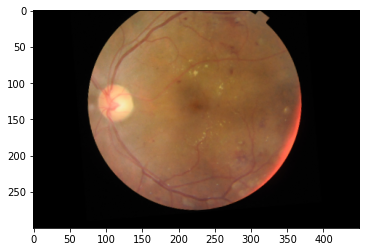

tensor([3])


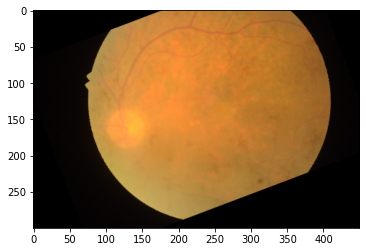

tensor([3])


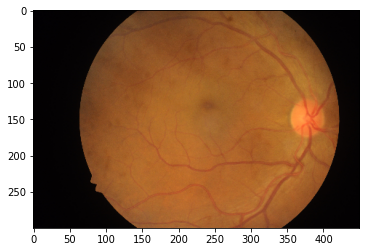

tensor([1])


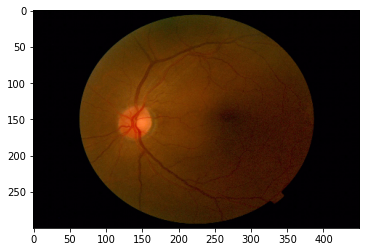

tensor([3])


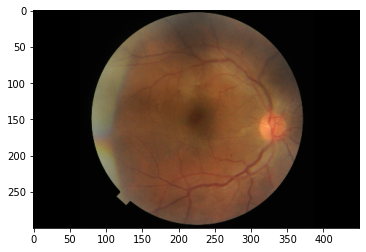

tensor([0])


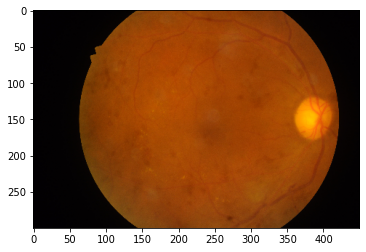

tensor([1])


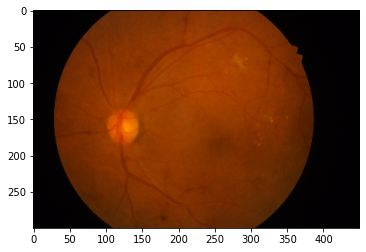

tensor([3])


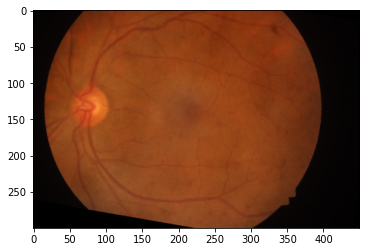

In [32]:
for b, sample in enumerate(training_dataloader):
    t_img = np.transpose(sample["image"], (0,2,3,1))
    t_label = sample["label"]
    print(t_img.shape)
    
    for idx in range(param_batch_size):
        print(sample["label"][idx])
        plt.figure()
        plt.imshow(t_img[idx,:,:,:])
        plt.show()
    break

# 4. Define network and  training parameters

### 4.1 Earling Stopping
The early stopping class ensures that the best model corresponding to the lowest validation score is stored and if the validation performance does not improve after a certain number of epochs, the model training stops. 

In [29]:
# Early Stopping Functions
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

### 4.2 Define the model

In [30]:
model = torchvision.models.mobilenet_v2(pretrained=True)
model.classifier = nn.Linear(1280, 4)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 4.3 Model Training Parameters

In [33]:
patience_es = 10 #patience for early stopping
weights = [2, 2, 4, 1] #class weights to account for class imbalance
param_lr = 1e-4 #learning rate for the optimizer
param_weight_decay = 1e-5 #weight decay for the optimizer
num_epochs = 30 # number of epochs we should train the model
# choice of learning rate scheduler
# choice of optimizer

## 5. Train the model

In [32]:
# mkdir for stored models
!mkdir models
!mkdir checkpoints

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience_es, verbose=True)

train_loss_all = []
train_acc_all = []
val_loss_all = []
val_acc_all = []

model_name = 'model_workshop'


# define the optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=param_lr, weight_decay=param_weight_decay)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 10)

# send the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = model.to(device)

class_weights = torch.FloatTensor(weights).to(device)

criterion = nn.CrossEntropyLoss()

# training loop
training = True
epoch = 1
try:
    while training:
    
        # epoch specific metrics
        train_loss = 0
        mask_loss = 0
        train_accuracy = 0
        val_loss = 0
        val_accuracy = 0
        total_loss = 0
        # -----------------------------
        # training samples
        # -----------------------------
        
        # set the model into train mode
        model.train()
        for b, batch in enumerate(Bar(training_dataloader)):


                x = batch['image'].to(device).float()
                y = batch['label'].to(device).long()

                # clear gradients
                optimizer.zero_grad()
                
                # infer the current batch 
                pred = model(x)
                
                # compute the loss. 
                loss = criterion(pred, y.squeeze())
                train_loss += loss.item()
                
                # backward loss and next step
                loss.backward()
                optimizer.step()
                
                # compute the accuracy
                pred = pred.max(1, keepdim=True)[1]
                batch_accuracy = pred.eq(y.view_as(pred).long())
                train_accuracy += (batch_accuracy.sum().item() / np.prod(y.shape))
                
                
        # -----------------------------
        # validation samples
        # -----------------------------
    
        # set the model into train mode
        model.eval()
        for b, batch in enumerate(Bar(validation_dataloader)):

                x = batch['image'].to(device).float()
                y = batch['label'].to(device).long()

                # infer the current batch 
                with torch.no_grad():
                    pred = model(x)
                    loss = criterion(pred, y.squeeze())
                    val_loss += loss.item()
                
                    # compute the accuracy 
                    pred = pred.max(1, keepdim=True)[1]
                    batch_accuracy = pred.eq(y.view_as(pred).long())
                    val_accuracy += batch_accuracy.sum().item() / np.prod(y.shape) 
                #scheduler.step(val_loss)

        # compute mean metrics
        train_loss /= (len(training_dataloader))
        train_accuracy /= (len(training_dataloader))
        val_loss /= (len(validation_dataloader))
        val_accuracy /= (len(validation_dataloader))
        early_stopping(val_loss, model)
    
        train_loss_all.append(train_loss)
        train_acc_all.append(train_accuracy)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_accuracy)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        print('Epoch {:d} train_loss {:.4f} train_acc {:.4f} val_loss {:.4f} val_acc {:.4f}'.format(
            epoch, 
            train_loss, 
            train_accuracy,
            val_loss,
            val_accuracy))
        # update epochs
        epoch += 1
        
        # save weights
        torch.save(model.state_dict(), 
                  os.path.join('models', 'model' + str(epoch) + '.pth'))

        if epoch >= num_epochs:
            training = False
except KeyboardInterrupt:
    pass
                        

mkdir: cannot create directory ‘models’: File exists
mkdir: cannot create directory ‘checkpoints’: File exists
1536/1536: [===============================>] - ETA 8.4s
384/384: [===============================>] - ETA 0.0s
Validation loss decreased (inf --> 0.596258).  Saving model ...
Epoch 1 train_loss 0.8120 train_acc 0.6771 val_loss 0.5963 val_acc 0.7370
1536/1536: [===============================>] - ETA 0.1s
384/384: [===============================>] - ETA 0.0s
Validation loss decreased (0.596258 --> 0.520972).  Saving model ...
Epoch 2 train_loss 0.6500 train_acc 0.7194 val_loss 0.5210 val_acc 0.7891
1536/1536: [===============================>] - ETA 0.1s
384/384: [===============================>] - ETA 0.0s
EarlyStopping counter: 1 out of 5
Epoch 3 train_loss 0.5753 train_acc 0.7669 val_loss 0.5364 val_acc 0.7630
1536/1536: [===============================>] - ETA 0.1s
384/384: [===============================>] - ETA 0.0s
EarlyStopping counter: 2 out of 5
Epoch 4 train_loss

# 6. Testing the Model and Creating Predictions

### 6.1 Defining the multi-class ROC curve function (One vs. All)

In [34]:
def plot_multiclass_roc(preds, y_test, n_classes, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], preds[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')

    
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))

    ax.grid(alpha=.4)
    ax.legend()
    sns.despine()
    plt.show()

### 6.2 Testing on the Training Dataset

In [35]:
# loading the best checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
if device.type == "cuda":
  model.load_state_dict(torch.load("checkpoint.pt"))
elif device.type == "cpu":
  model.load_state_dict(torch.load("/content/drive/MyDrive/retinal_disease_classification/checkpoint.pt", map_location=torch.device('cpu')))

model = model.to(device)

# setting the model in evaluation model
model.eval()
count = 0

# getting predictions
pred_t = []
label_t = []
out_t = []
for b, batch in enumerate(Bar(training_dataloader)):
    x = batch['image'].to(device).float()
    y = batch['label'].detach().numpy()
    
    # infer the current batch 
    with torch.no_grad():
        pred = model(x)

    for i in range(len(y)):
        pred_t.append(np.squeeze(F.softmax(pred[i]).cpu().detach().numpy()))
        label_t.append(y[i])
        out_t.extend(pred.max(1, keepdim=True)[1].cpu().detach().numpy()[i])

  32/1536: [>...............................] - ETA 12.1s

<ipython-input-35-30e0bdf4c108>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_t.append(np.squeeze(F.softmax(pred[i]).cpu().detach().numpy()))


1536/1536: [===============================>] - ETA 0.1s


In [39]:
!cp checkpoint.pt /content/drive/MyDrive/checkpoint_fyp.pt

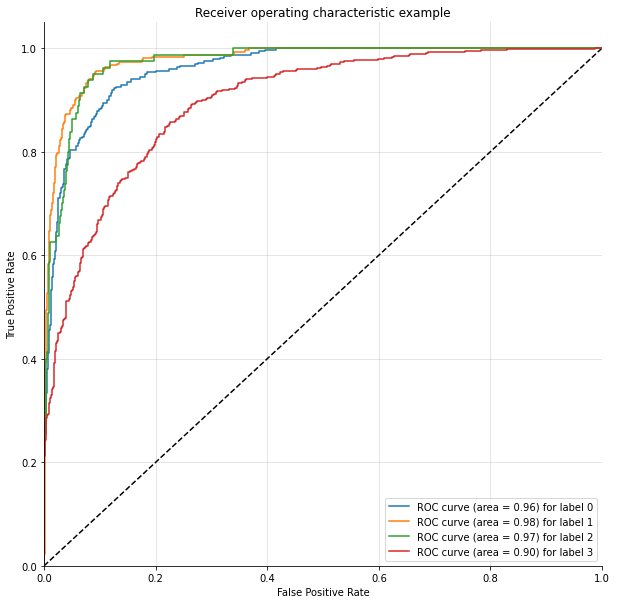

                                  precision    recall  f1-score   support

                 no disease risk       0.74      0.84      0.79       321
            diabetic retinopathy       0.91      0.73      0.81       300
age related macular degeneration       0.77      0.42      0.55        80
                  other diseases       0.80      0.85      0.83       835

                        accuracy                           0.81      1536
                       macro avg       0.81      0.71      0.75      1536
                    weighted avg       0.81      0.81      0.80      1536



In [36]:
# plotting the multi-class ROC Curve
predicted_prob = np.vstack(pred_t)
true_labels = np.array(label_t)

onehot_encoder = OneHotEncoder(sparse=False)
true_labels = true_labels.reshape(len(true_labels), 1)
true_labels = onehot_encoder.fit_transform(true_labels)

plot_multiclass_roc(predicted_prob, true_labels, n_classes=4, figsize=(10, 10))
print(classification_report(label_t, out_t, target_names=["no disease risk", "diabetic retinopathy", "age related macular degeneration", "other diseases"]))

### 6.3 Testing on the Validation Dataset

In [37]:
# loading the best checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
if device.type == "cuda":
  model.load_state_dict(torch.load("checkpoint.pt"))
elif device.type == "cpu":
  model.load_state_dict(torch.load("/content/drive/MyDrive/retinal_disease_classification/checkpoint.pt", map_location=torch.device('cpu')))
model = model.to(device)

# setting the model in evaluation model
model.eval()
count = 0

# getting predictions
pred_t = []
label_t = []
out_t = []
for b, batch in enumerate(Bar(validation_dataloader)):
    x = batch['image'].to(device).float()
    y = batch['label'].detach().numpy()
    
    # infer the current batch 
    with torch.no_grad():
        pred = model(x)

    for i in range(len(y)):
        pred_t.append(np.squeeze(F.softmax(pred[i]).cpu().detach().numpy()))
        label_t.append(y[i])
        out_t.extend(pred.max(1, keepdim=True)[1].cpu().detach().numpy()[i])

 40/384: [==>.............................] - ETA 2.0s

<ipython-input-37-9c1c21761163>:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_t.append(np.squeeze(F.softmax(pred[i]).cpu().detach().numpy()))


384/384: [===============================>] - ETA 0.0s


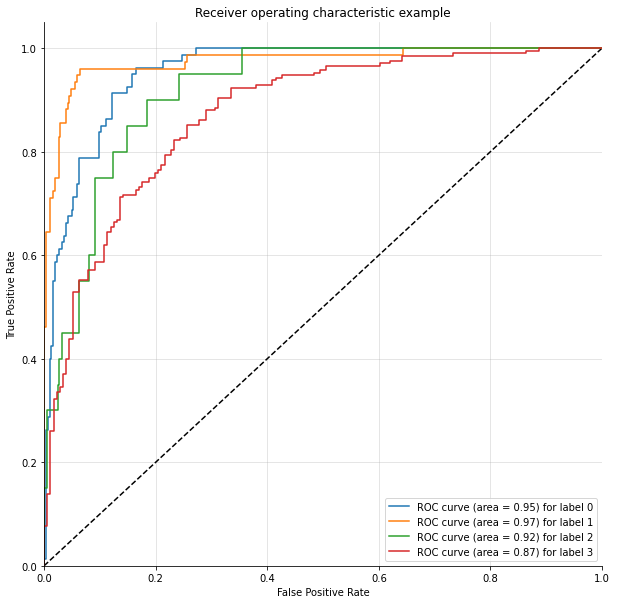

                                  precision    recall  f1-score   support

                 no disease risk       0.78      0.68      0.72        80
            diabetic retinopathy       0.90      0.79      0.84        76
age related macular degeneration       0.55      0.30      0.39        20
                  other diseases       0.77      0.88      0.82       208

                        accuracy                           0.79       384
                       macro avg       0.75      0.66      0.69       384
                    weighted avg       0.79      0.79      0.78       384



In [38]:
# plotting the multi-class ROC Curve
predicted_prob = np.vstack(pred_t)
true_labels = np.array(label_t)

onehot_encoder = OneHotEncoder(sparse=False)
true_labels = true_labels.reshape(len(true_labels), 1)
true_labels = onehot_encoder.fit_transform(true_labels)
plot_multiclass_roc(predicted_prob, true_labels, n_classes=4, figsize=(10, 10))
print(classification_report(label_t, out_t, target_names=["no disease risk", "diabetic retinopathy", "age related macular degeneration", "other diseases"]))

### 6.4 Testing on the Test Dataset

In [42]:
# loading the best checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
if device.type == "cuda":
  model.load_state_dict(torch.load("checkpoint.pt"))
elif device.type == "cpu":
  model.load_state_dict(torch.load("/content/drive/MyDrive/retinal_disease_classification/checkpoint.pt", map_location=torch.device('cpu')))
model = model.to(device)

# setting the model in evaluation model
model.eval()
idx = 0

# getting predictions
pred_t = []
label_t = []
out_t = []

for  img_n in tqdm(test_images):

    # pre-processing the test image
    temp_img_arr = cv2.imread(img_n)
    temp_img_arr = np.flip(temp_img_arr, 2)
    temp_img_arr = np.transpose(np.expand_dims(pre_process(temp_img_arr), axis=0), (0,3,1,2))
    temp_img_arr = torch.tensor(temp_img_arr)

    x = temp_img_arr.to(device).float()
    y = test_labels[idx]
    
    # infer the current batch 
    with torch.no_grad():
        pred = model(x)

    for i in range(len(y)):
        pred_t.append(np.squeeze(F.softmax(pred[i]).cpu().detach().numpy()))
        label_t.append(y[i])
        out_t.extend(pred.max(1, keepdim=True)[1].cpu().detach().numpy()[i])
        
    idx += 1

<ipython-input-42-71fdc9a9b481>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for  img_n in tqdm(test_images):


  0%|          | 0/640 [00:00<?, ?it/s]

<ipython-input-42-71fdc9a9b481>:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_t.append(np.squeeze(F.softmax(pred[i]).cpu().detach().numpy()))


KeyboardInterrupt: ignored

In [ ]:
# plotting the multi-class ROC Curve
predicted_prob = np.vstack(pred_t)
true_labels = np.array(label_t)

onehot_encoder = OneHotEncoder(sparse=False)
true_labels = true_labels.reshape(len(true_labels), 1)
true_labels = onehot_encoder.fit_transform(true_labels)

plot_multiclass_roc(predicted_prob, true_labels, n_classes=4, figsize=(10, 10))
print(classification_report(label_t, out_t, target_names=["no disease risk", "diabetic retinopathy", "age related macular degeneration", "other diseases"]))

### 6.5 Testing with Test time augmentation (TTA)
Test time augmentation (TTA) is a popular technique in computer vision. TTA aims at boosting the model accuracy by using data augmentation on the inference stage. The idea behind TTA is simple: for each test image, we create multiple versions that are a little different from the original image and average the output predictions for each of those transformed images, resutling in a final prediction more robust. 

In [ ]:
# test transform to apply TTA
test_transform =A.Compose([A.ShiftScaleRotate(shift_limit = 0.1, rotate_limit = 30, always_apply=False, p=0.5, border_mode=cv2.BORDER_CONSTANT),
                              A.HorizontalFlip(p=0.5),
                              A.VerticalFlip(p=0.5)])
tta_num = 5

# loading the best checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
if device.type == "cuda":
  model.load_state_dict(torch.load("checkpoint.pt"))
elif device.type == "cpu":
  model.load_state_dict(torch.load("/content/drive/MyDrive/retinal_disease_classification/checkpoint.pt", map_location=torch.device('cpu')))
model = model.to(device)

# setting the model in evaluation model
model.eval()
idx = 0

# getting predictions
pred_t = []
label_t = []
out_t = []

for  img_n in tqdm(test_images):

    # pre-processing the test image
    temp_img_arr = cv2.imread(img_n)
    temp_img_arr = np.flip(temp_img_arr, 2)
    temp_img_arr = pre_process(temp_img_arr)

    pred_s = []
    for i in range(5):
        temp_img_arr_t = test_transform(image=temp_img_arr)["image"]
        temp_img_arr_t = np.transpose(np.expand_dims(temp_img_arr_t, axis=0), (0,3,1,2))
        temp_img_arr_t = torch.tensor(temp_img_arr_t)

        x = temp_img_arr_t.to(device).float()
        y = test_labels[idx]

        # infer the current batch 
        with torch.no_grad():
            pred = model(x)
            pred_s.append(np.squeeze(F.softmax(pred).cpu().detach().numpy()))
        
    pred_s_t = np.sum(pred_s, axis = 0)/tta_num
    
    pred_t.append(pred_s_t)
    label_t.append(y)
    out_t.extend([np.argmax(pred_s_t, axis=0)])
        
    idx += 1
    

In [ ]:
# plotting the multi-class ROC Curve
predicted_prob = np.vstack(pred_t)
true_labels = np.array(label_t)

onehot_encoder = OneHotEncoder(sparse=False)
true_labels = true_labels.reshape(len(true_labels), 1)
true_labels = onehot_encoder.fit_transform(true_labels)

plot_multiclass_roc(predicted_prob, true_labels, n_classes=4, figsize=(10, 10))
print(classification_report(label_t, out_t, target_names=["no disease risk", "diabetic retinopathy", "age related macular degeneration", "other diseases"]))

## 7. Grad-CAMS for interpretability

Grad-CAMs are used for interpretability. They highlight the area that the model considers important for prediction. 

In [ ]:
# loading the best checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
if device.type == "cuda":
  model.load_state_dict(torch.load("checkpoint.pt"))
elif device.type == "cpu":
  model.load_state_dict(torch.load("/content/drive/MyDrive/retinal_disease_classification/checkpoint.pt", map_location=torch.device('cpu')))
model = model.to(device)

# setting the model in evaluation model
model.eval()
count = 0

# defining the GradCAM layer
gradcam = LayerGradCam(model, model.features[15])

# getting predictions
for b, batch in enumerate(Bar(validation_dataloader)):
    x = batch['image'].to(device).float()
    y = batch['label'].detach().numpy()
    
    # infer the current batch 
    with torch.no_grad():
        pred = model(x)

    for i in range(len(y)):
        predicted_label = np.argmax(np.squeeze(F.softmax(pred[i]).cpu().detach().numpy()), axis=0)
        true_label = np.squeeze(y[i])
        
        if true_label == predicted_label:
            print("\n Label: ", true_label, "-", new_labels[true_label])
            
            # check the gradcam for the correct prediction
            attributions = gradcam.attribute(torch.unsqueeze(x[i], 0), target=torch.tensor(true_label))
            attributions = attributions.cpu().detach().numpy()
            attributions = np.transpose(attributions[0], (1,2,0)) 
            attributions = (attributions - np.min(attributions))/(np.max(attributions) - np.min(attributions))
            attributions = cv2.resize(attributions,(450,300))
            
            plt.figure(figsize=(10,10))
            plt.subplot(1,3,1)
            plt.imshow(np.transpose(batch['image'][i], (1,2,0)))
            plt.title("Original Image")
 
            plt.subplot(1,3,2)
            plt.imshow(attributions, cmap=plt.cm.RdBu_r)
            plt.title("Grad-CAM")
            
            plt.subplot(1,3,3)
            img = np.transpose(batch['image'][i], (1,2,0)).numpy()
            norm_img = (img - np.min(img))/(np.max(img) - np.min(img))
            plt.imshow(norm_img)
            plt.imshow(attributions, alpha = 0.5, cmap=plt.cm.RdBu_r)
            plt.title("Overlayed Grad-CAM")
            plt.show()
    break